## Feature selection and enigneering

### 1) Data cleaning and pre-processing

In [1]:
# import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import gc

In [2]:
# load data (train.csv will be the complete dataset for predictive modeling, ignore Test.csv for now)
data=pd.read_csv("./data/Train.csv")

#### Convert the sensor data for each feature from string type into a list of values

In [3]:
# define a function to replace spaces in the string (i.e. missings) with NaN
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

# define list of feature names
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]


for feature in features : 
    # first replace every 'nan' in a cell with an empty space, split using comma, and then apply replace_nan function on every item
    data[feature]=data[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])    

### Features engineering

#### calculate percent NaN for each recording period per feature

In [4]:
# recording periods contain varying degrees of NaNs: compute percent NaN for each recording period and feature
# function to compute the percentage of NaNs per recording period
def compute_percent_nan(df, col_name):
    df['percent_nan_'+col_name] = df[col_name].apply(lambda x: np.isnan(np.array(x)).sum()/len(x)*100)
    return df

In [5]:
# calculate percentage of missings per recording period and feature and append to dataframe
for col_name in tqdm(features):
    data=compute_percent_nan(data,col_name)

100%|██████████| 6/6 [00:00<00:00, 11.39it/s]


#### Remove NaNs from lists of raw data and extract summary statistics

In [6]:
# aggregation function extracting summary statistics from every recording period and appending it as a new column to a dataframe
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  

# function returning only non-Null values (helper for aggregation function)
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [7]:
# remove NaNs from dataframe
for col_name in tqdm(features):
   data[col_name]=data[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:00<00:00,  9.15it/s]


In [8]:
#extract summary statistics for each recording period and feature
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


##### Extract individual raw values from list for each feature and append as separate columns

In [9]:
# extract all single raw values from each feature and append them as new columns to the dataframe
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_2789/268327596.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_2789/268327596.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_2789/268327596.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

#### drop raw data contained in lists

In [10]:
# drop raw sensor data contained as list from the initial dataset
data.drop(features,1,inplace=True)

/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_2789/1401606462.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(features,1,inplace=True)


In [11]:
data.head()

ID location      target  percent_nan_temp  percent_nan_precip  \
0     ID_train_0        C   45.126304         86.776860           86.776860   
1     ID_train_1        D   79.131702          0.000000            0.000000   
2    ID_train_10        A   32.661304          0.826446            0.826446   
3   ID_train_100        A   53.850238          0.000000            0.000000   
4  ID_train_1000        A  177.418750         75.206612           75.206612   

   percent_nan_rel_humidity  percent_nan_wind_dir  percent_nan_wind_spd  \
0                 86.776860             86.776860             86.776860   
1                  0.000000              0.000000              0.000000   
2                  0.826446             38.016529             38.016529   
3                  0.000000             42.148760             42.148760   
4                 75.206612             75.206612             75.206612   

   percent_nan_atmos_press   max_temp  ...  newrel_humidity119  \
0                86.776860  27.208333  ...                 NaN   
1                 0.000000  33.616667  ...            0.649250   
2                 0.826446  31.841667  ...            0.437917   
3                 0.000000  27.491667  ...            0.766417   
4                75.206612  28.750000  ...                 NaN   

   newwind_dir119  windspeed119  atmospherepressure119  newtemp120  \
0             NaN           NaN                    NaN         NaN   
1       73.528733      1.475833              90.439167   21.450000   
2             NaN           NaN              88.415833         NaN   
3             NaN           NaN              88.490833   24.641667   
4             NaN           NaN                    NaN         NaN   

   newprecip120  newrel_humidity120  newwind_dir120  windspeed120  \
0           NaN                 NaN             NaN           NaN   
1         0.561            0.797333      296.967254      1.019167   
2           NaN                 NaN             NaN           NaN   
3         0.000            0.719667             NaN           NaN   
4           NaN                 NaN             NaN           NaN   

   atmospherepressure120  
0                    NaN  
1              90.529167  
2                    NaN  
3              88.465833  
4                    NaN  

[5 rows x 777 columns]

#### select last 5 measurement points for each feature

In [12]:
last = data.columns[-30:].tolist()
last

['newtemp116',
 'newprecip116',
 'newrel_humidity116',
 'newwind_dir116',
 'windspeed116',
 'atmospherepressure116',
 'newtemp117',
 'newprecip117',
 'newrel_humidity117',
 'newwind_dir117',
 'windspeed117',
 'atmospherepressure117',
 'newtemp118',
 'newprecip118',
 'newrel_humidity118',
 'newwind_dir118',
 'windspeed118',
 'atmospherepressure118',
 'newtemp119',
 'newprecip119',
 'newrel_humidity119',
 'newwind_dir119',
 'windspeed119',
 'atmospherepressure119',
 'newtemp120',
 'newprecip120',
 'newrel_humidity120',
 'newwind_dir120',
 'windspeed120',
 'atmospherepressure120']

#### select percent NaN columns and summary statistics

In [13]:
# list dataframe columns for target and condensed features, including percent NaNs
summary_columns = data.columns[:51].tolist()
summary_columns

['ID',
 'location',
 'target',
 'percent_nan_temp',
 'percent_nan_precip',
 'percent_nan_rel_humidity',
 'percent_nan_wind_dir',
 'percent_nan_wind_spd',
 'percent_nan_atmos_press',
 'max_temp',
 'min_temp',
 'mean_temp',
 'std_temp',
 'var_temp',
 'median_temp',
 'ptp_temp',
 'max_precip',
 'min_precip',
 'mean_precip',
 'std_precip',
 'var_precip',
 'median_precip',
 'ptp_precip',
 'max_rel_humidity',
 'min_rel_humidity',
 'mean_rel_humidity',
 'std_rel_humidity',
 'var_rel_humidity',
 'median_rel_humidity',
 'ptp_rel_humidity',
 'max_wind_dir',
 'min_wind_dir',
 'mean_wind_dir',
 'std_wind_dir',
 'var_wind_dir',
 'median_wind_dir',
 'ptp_wind_dir',
 'max_wind_spd',
 'min_wind_spd',
 'mean_wind_spd',
 'std_wind_spd',
 'var_wind_spd',
 'median_wind_spd',
 'ptp_wind_spd',
 'max_atmos_press',
 'min_atmos_press',
 'mean_atmos_press',
 'std_atmos_press',
 'var_atmos_press',
 'median_atmos_press',
 'ptp_atmos_press']

### append column names containing last 5 measurement points to summary_columns

In [14]:
summary_columns.extend(last)

In [15]:
# select data with summary statistics for the different features
df_condensed = data[summary_columns]
df_condensed.set_index('ID', drop=True, inplace=True)
df_condensed.head()

location      target  percent_nan_temp  percent_nan_precip  \
ID                                                                         
ID_train_0           C   45.126304         86.776860           86.776860   
ID_train_1           D   79.131702          0.000000            0.000000   
ID_train_10          A   32.661304          0.826446            0.826446   
ID_train_100         A   53.850238          0.000000            0.000000   
ID_train_1000        A  177.418750         75.206612           75.206612   

               percent_nan_rel_humidity  percent_nan_wind_dir  \
ID                                                              
ID_train_0                    86.776860             86.776860   
ID_train_1                     0.000000              0.000000   
ID_train_10                    0.826446             38.016529   
ID_train_100                   0.000000             42.148760   
ID_train_1000                 75.206612             75.206612   

               percent_nan_wind_spd  percent_nan_atmos_press   max_temp  \
ID                                                                        
ID_train_0                86.776860                86.776860  27.208333   
ID_train_1                 0.000000                 0.000000  33.616667   
ID_train_10               38.016529                 0.826446  31.841667   
ID_train_100              42.148760                 0.000000  27.491667   
ID_train_1000             75.206612                75.206612  28.750000   

                min_temp  ...  newrel_humidity119  newwind_dir119  \
ID                        ...                                       
ID_train_0     19.275000  ...                 NaN             NaN   
ID_train_1     17.983333  ...            0.649250       73.528733   
ID_train_10    18.458333  ...            0.437917             NaN   
ID_train_100   16.941667  ...            0.766417             NaN   
ID_train_1000  17.525000  ...                 NaN             NaN   

               windspeed119  atmospherepressure119  newtemp120  newprecip120  \
ID                                                                             
ID_train_0              NaN                    NaN         NaN           NaN   
ID_train_1         1.475833              90.439167   21.450000         0.561   
ID_train_10             NaN              88.415833         NaN           NaN   
ID_train_100            NaN              88.490833   24.641667         0.000   
ID_train_1000           NaN                    NaN         NaN           NaN   

               newrel_humidity120  newwind_dir120  windspeed120  \
ID                                                                
ID_train_0                    NaN             NaN           NaN   
ID_train_1               0.797333      296.967254      1.019167   
ID_train_10                   NaN             NaN           NaN   
ID_train_100             0.719667             NaN           NaN   
ID_train_1000                 NaN             NaN           NaN   

               atmospherepressure120  
ID                                    
ID_train_0                       NaN  
ID_train_1                 90.529167  
ID_train_10                      NaN  
ID_train_100               88.465833  
ID_train_1000                    NaN  

[5 rows x 80 columns]

In [16]:
df_condensed.iloc[:,-30:].info()

<class 'pandas.core.frame.DataFrame'>
Index: 15539 entries, ID_train_0 to ID_train_9999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   newtemp116             13125 non-null  float64
 1   newprecip116           13157 non-null  float64
 2   newrel_humidity116     13227 non-null  float64
 3   newwind_dir116         9449 non-null   float64
 4   windspeed116           9449 non-null   float64
 5   atmospherepressure116  13228 non-null  float64
 6   newtemp117             13110 non-null  float64
 7   newprecip117           13142 non-null  float64
 8   newrel_humidity117     13213 non-null  float64
 9   newwind_dir117         9099 non-null   float64
 10  windspeed117           9099 non-null   float64
 11  atmospherepressure117  13214 non-null  float64
 12  newtemp118             13079 non-null  float64
 13  newprecip118           13110 non-null  float64
 14  newrel_humidity118     13058 non-null  flo

### Filter dataframe for observations with percent NaN < 30% for all features

In [17]:
# get NaN columns
nan_columns = ['percent_nan_temp', 'percent_nan_precip',
       'percent_nan_rel_humidity', 'percent_nan_wind_dir',
       'percent_nan_wind_spd', 'percent_nan_atmos_press']

In [18]:
# filter observations based on percent NaN and check again the data distribution of the target and summary features
df_filtered = df_condensed[(df_condensed[nan_columns]<30).all(axis=1)]
df_filtered.head()

location     target  percent_nan_temp  percent_nan_precip  \
ID                                                                         
ID_train_1            D  79.131702               0.0                 0.0   
ID_train_10000        E  17.005000               0.0                 0.0   
ID_train_10001        C  53.100000               0.0                 0.0   
ID_train_10002        A  55.051143               0.0                 0.0   
ID_train_10005        D  55.638261               0.0                 0.0   

                percent_nan_rel_humidity  percent_nan_wind_dir  \
ID                                                               
ID_train_1                      0.000000              0.000000   
ID_train_10000                  0.000000             14.049587   
ID_train_10001                  0.000000              0.000000   
ID_train_10002                  0.000000              3.305785   
ID_train_10005                  0.826446              1.652893   

                percent_nan_wind_spd  percent_nan_atmos_press   max_temp  \
ID                                                                         
ID_train_1                  0.000000                      0.0  33.616667   
ID_train_10000             14.049587                      0.0  28.416667   
ID_train_10001              0.000000                      0.0  29.266667   
ID_train_10002              3.305785                      0.0  29.483333   
ID_train_10005              1.652893                      0.0  34.041667   

                 min_temp  ...  newrel_humidity119  newwind_dir119  \
ID                         ...                                       
ID_train_1      17.983333  ...            0.649250       73.528733   
ID_train_10000  17.183333  ...            0.900083             NaN   
ID_train_10001  19.116667  ...            0.996667      157.853489   
ID_train_10002  16.933333  ...            0.997583             NaN   
ID_train_10005  17.191667  ...            0.759167             NaN   

                windspeed119  atmospherepressure119  newtemp120  newprecip120  \
ID                                                                              
ID_train_1          1.475833              90.439167   21.450000         0.561   
ID_train_10000           NaN              88.525000   25.075000         0.000   
ID_train_10001      0.684167              87.686667   19.508333         0.868   
ID_train_10002           NaN              88.181667   18.975000         0.000   
ID_train_10005           NaN              90.555833   20.491667         0.000   

                newrel_humidity120  newwind_dir120  windspeed120  \
ID                                                                 
ID_train_1                0.797333      296.967254      1.019167   
ID_train_10000            0.773000             NaN           NaN   
ID_train_10001            0.995833      207.023076      0.633333   
ID_train_10002            0.998500             NaN           NaN   
ID_train_10005                 NaN             NaN           NaN   

                atmospherepressure120  
ID                                     
ID_train_1                  90.529167  
ID_train_10000              88.510000  
ID_train_10001              87.663333  
ID_train_10002              88.175833  
ID_train_10005              90.531667  

[5 rows x 80 columns]

In [19]:
percent_reduc = (df_condensed.shape[0]-df_filtered.shape[0]) / df_condensed.shape[0]*100
print(f'Percent reduction in dataset size after filtering: {round(percent_reduc,1)}%')

Percent reduction in dataset size after filtering: 13.0%


In [20]:
df_filtered.iloc[:,-30:].info()

<class 'pandas.core.frame.DataFrame'>
Index: 13522 entries, ID_train_1 to ID_train_9999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   newtemp116             12669 non-null  float64
 1   newprecip116           12749 non-null  float64
 2   newrel_humidity116     12771 non-null  float64
 3   newwind_dir116         9401 non-null   float64
 4   windspeed116           9401 non-null   float64
 5   atmospherepressure116  12772 non-null  float64
 6   newtemp117             12654 non-null  float64
 7   newprecip117           12734 non-null  float64
 8   newrel_humidity117     12757 non-null  float64
 9   newwind_dir117         9051 non-null   float64
 10  windspeed117           9051 non-null   float64
 11  atmospherepressure117  12758 non-null  float64
 12  newtemp118             12623 non-null  float64
 13  newprecip118           12702 non-null  float64
 14  newrel_humidity118     12620 non-null  flo

Even with the filtered dataframe, there are many missings with respect to the last 5 measurement points. One may first define an imputation strategy before using these features for prediction. Otherwise, we would lose many observations.

#### Examine location-wise correlations between summary features and target

In [21]:
def plot_scatter(data, features, title):
    # define a list of locations
    locations = ['A', 'B', 'C', 'D', 'E']
    # define a list of associated colors
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    # generate dataframe with relevant variables
    new_df = pd.concat([df_filtered[['location', 'target']], df_filtered[features]], axis=1)

    fig = plt.figure(figsize=(15, 20))
    plt.suptitle(f'{title}\n', fontsize=18)

    k=1 # set index for subplot

    for row in range(1, len(features)+1):
        for col in range(1, 6):
            ax = fig.add_subplot(len(features), 5, k)
            subplot = sns.scatterplot(data=new_df[new_df.location == locations[col-1]], x=new_df.iloc[:,row+1], 
                                    y='target', color=colors[col-1])
            ax.set_title('Location ' + locations[col-1])
            k += 1

    fig.tight_layout()

In [22]:
df_filtered.columns[8:15]

Index(['max_temp', 'min_temp', 'mean_temp', 'std_temp', 'var_temp',
       'median_temp', 'ptp_temp'],
      dtype='object')

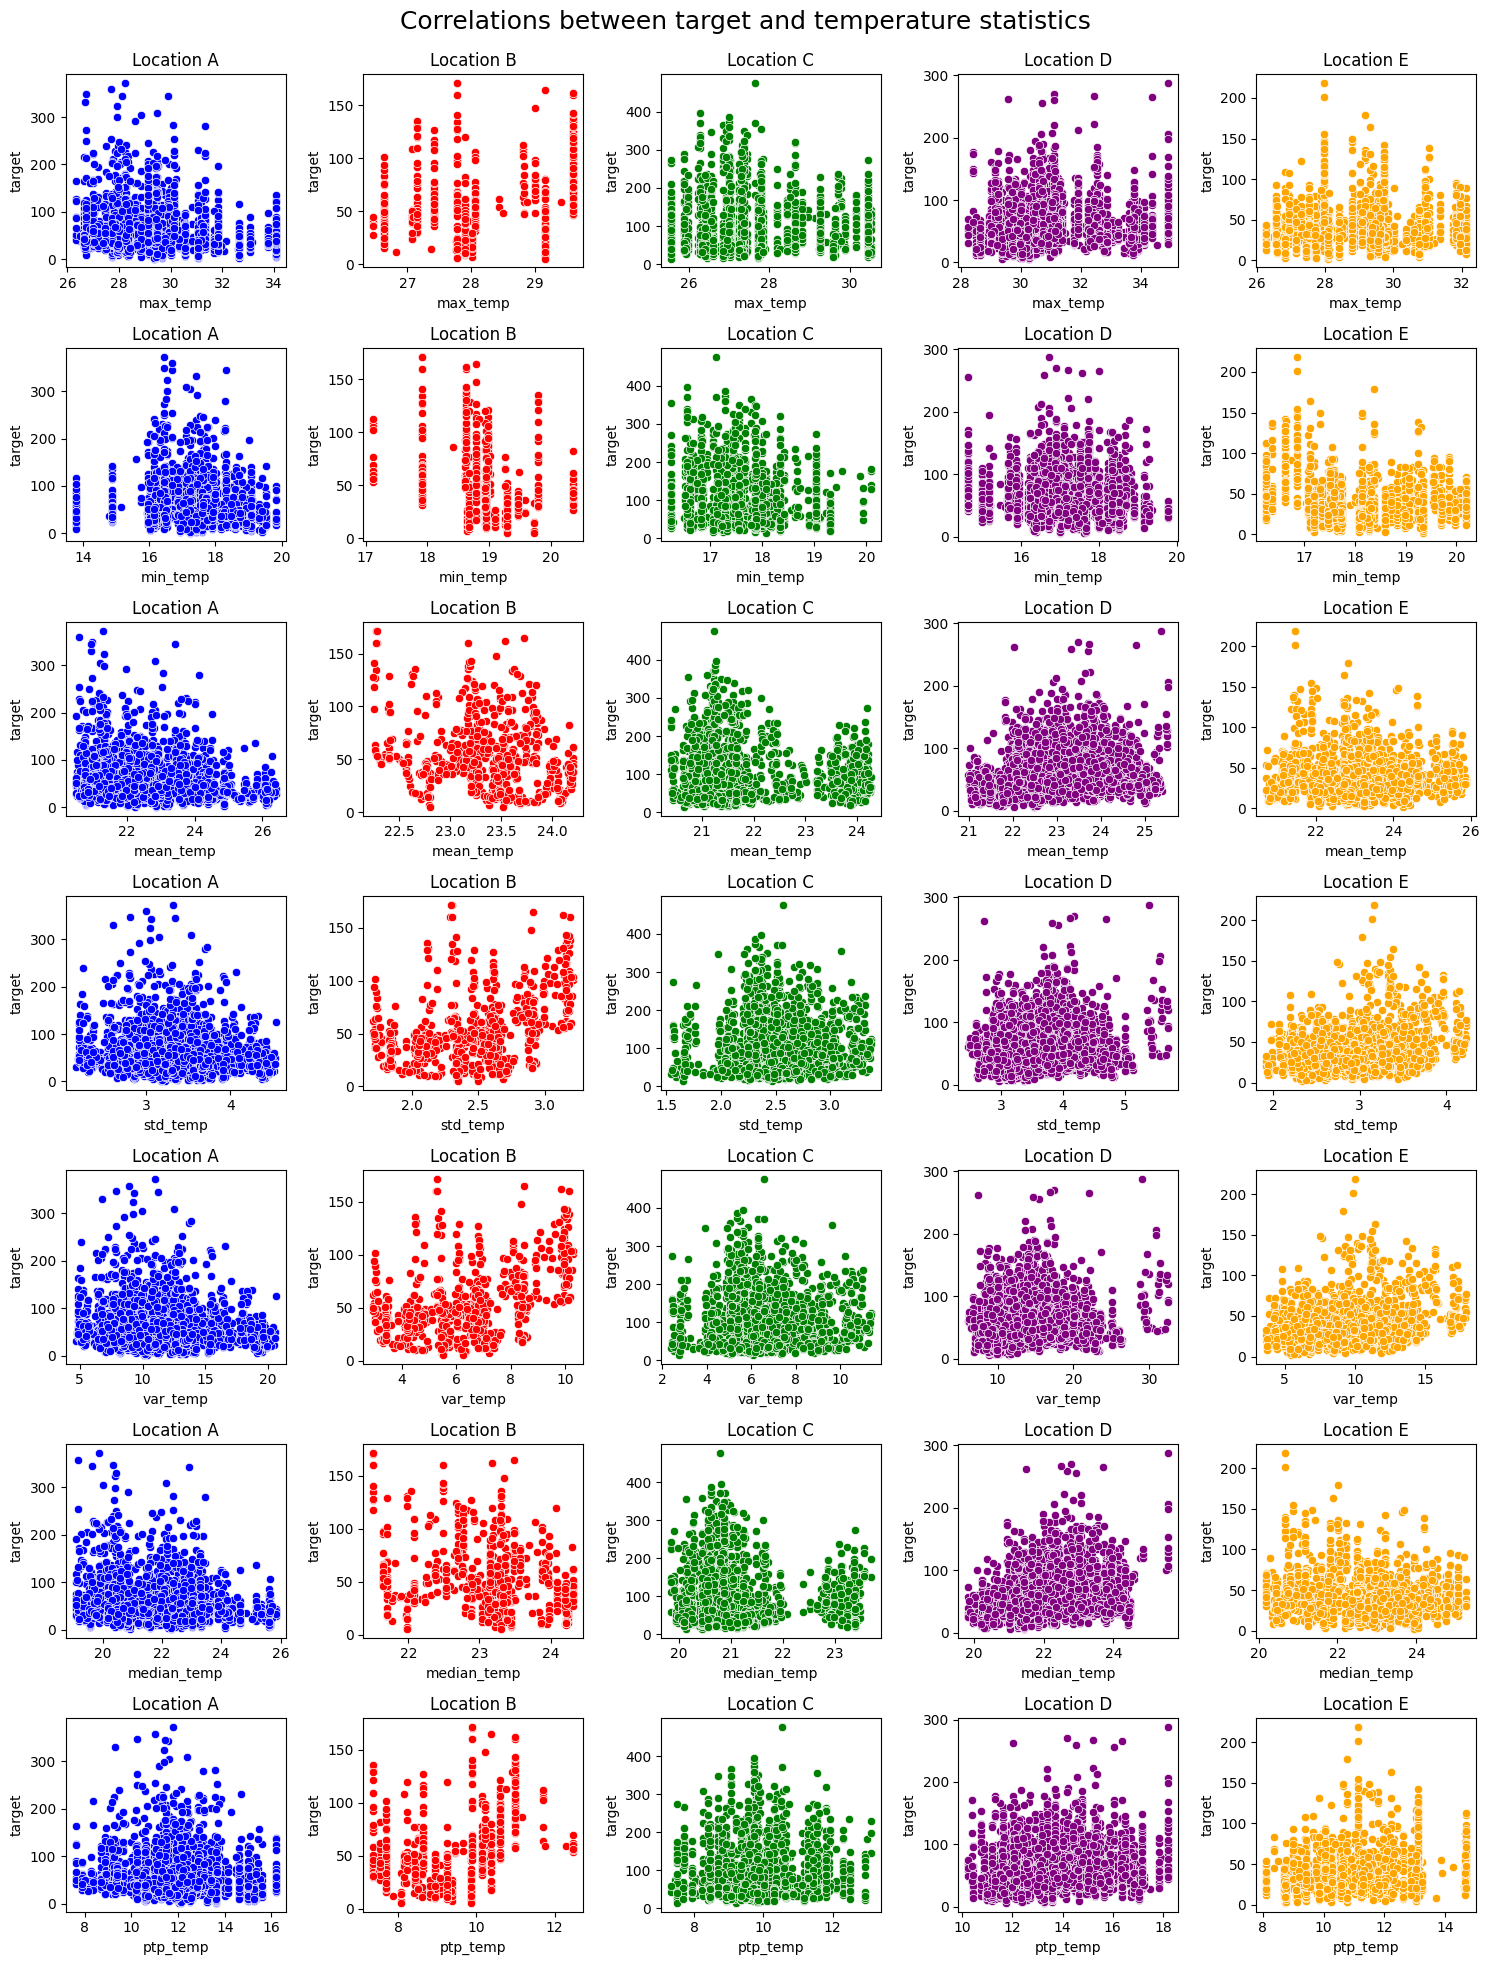

In [23]:
plot_scatter(df_filtered, df_filtered.columns[8:15].tolist(), 'Correlations between target and temperature statistics')

In [24]:
df_filtered.columns[15:22]

Index(['max_precip', 'min_precip', 'mean_precip', 'std_precip', 'var_precip',
       'median_precip', 'ptp_precip'],
      dtype='object')

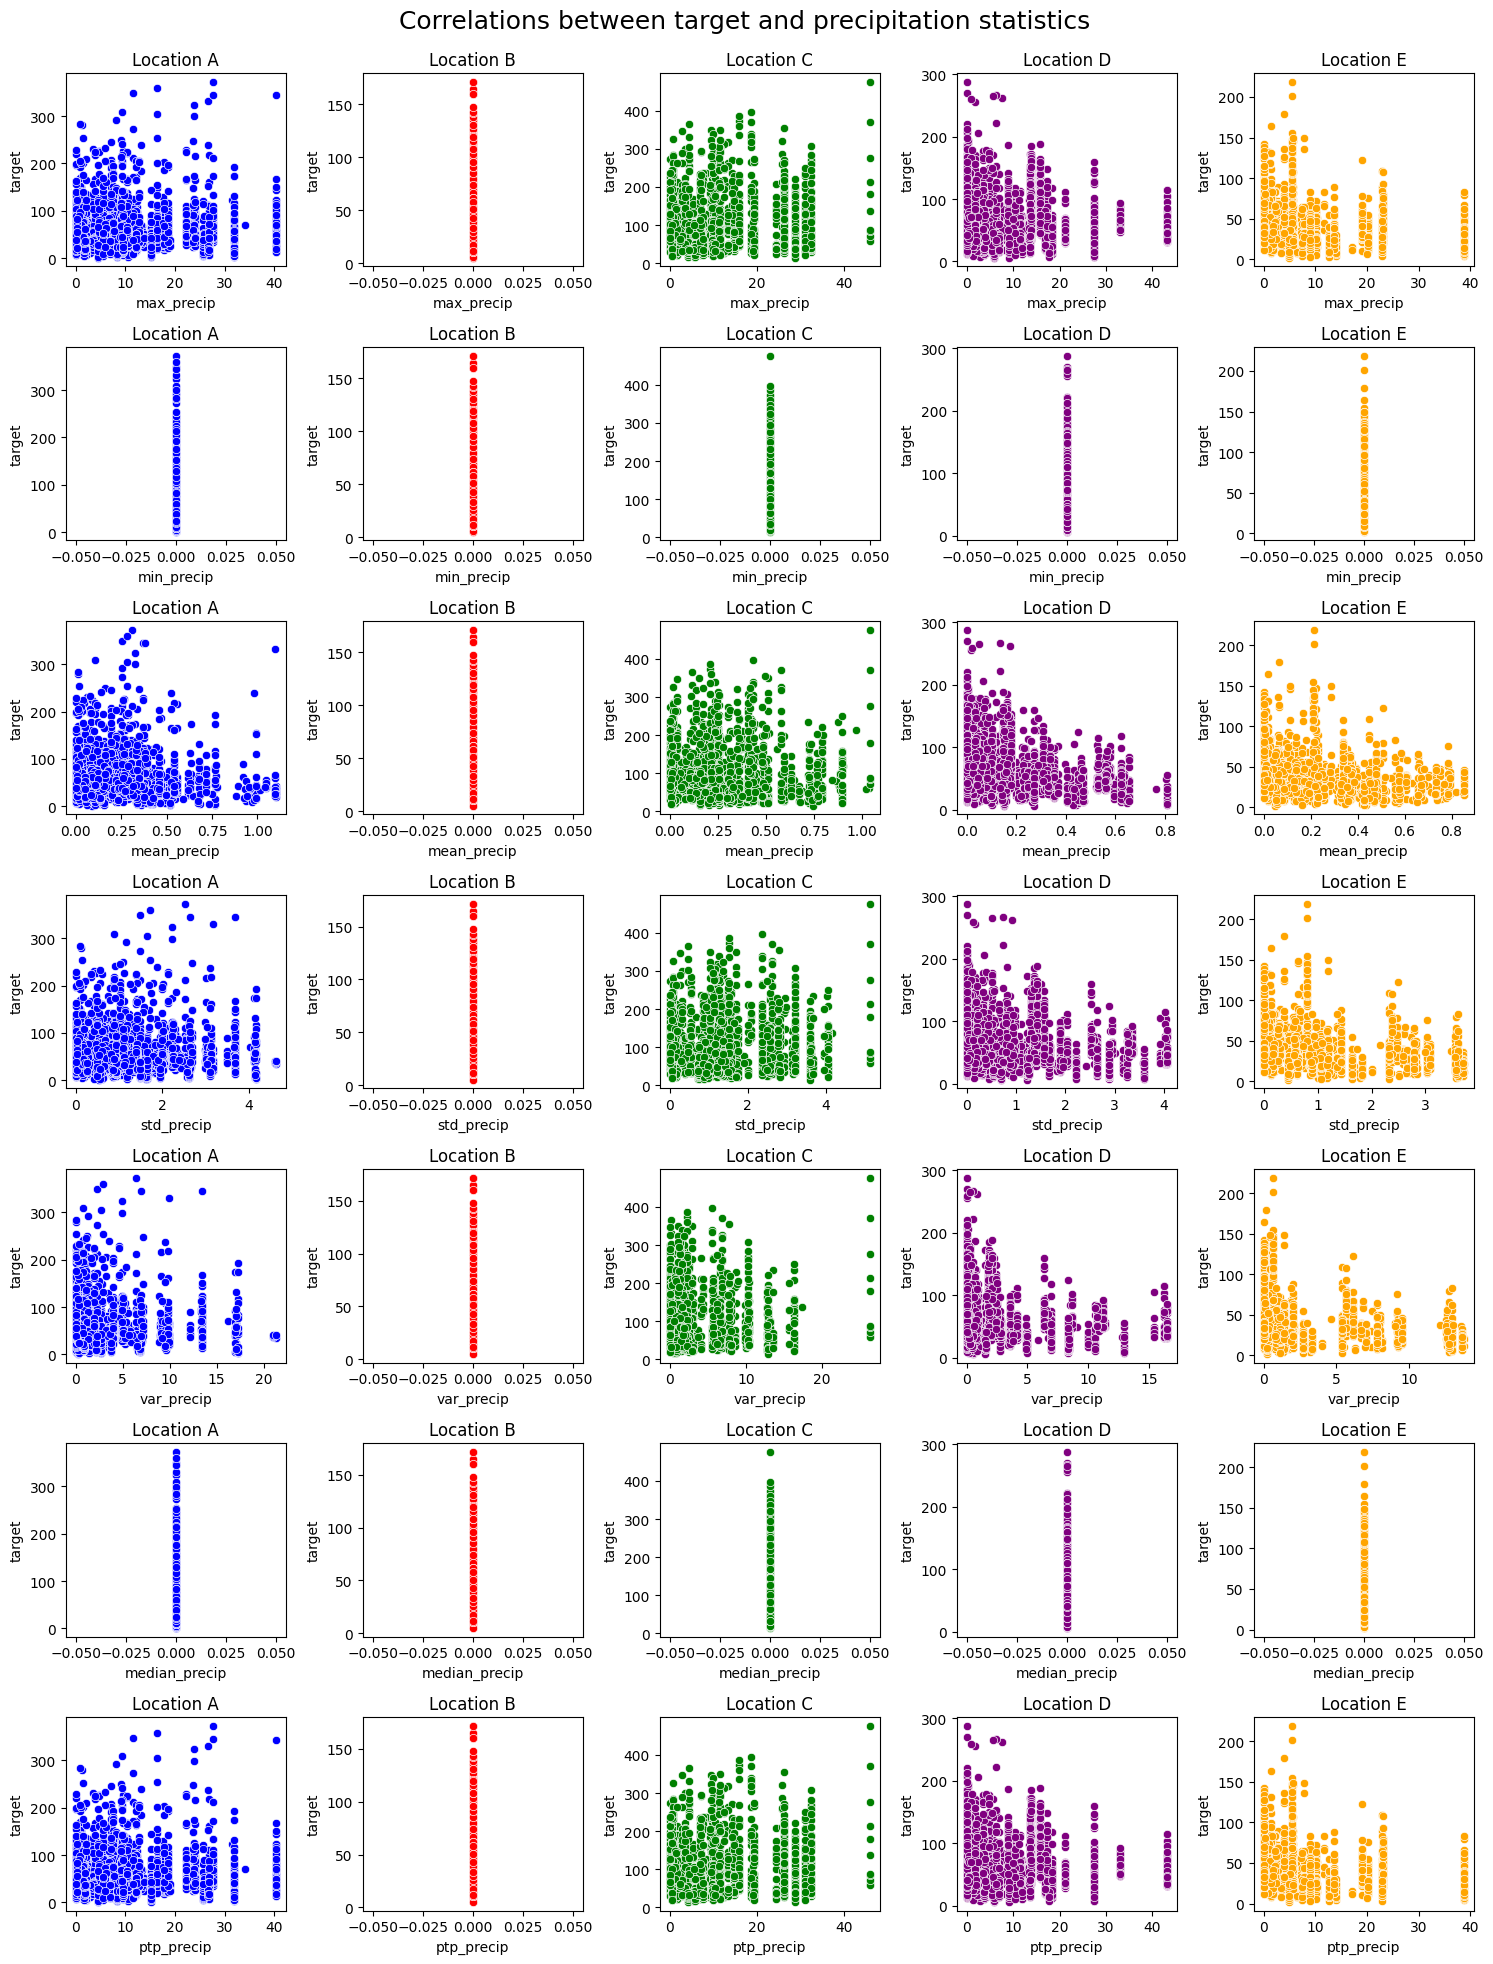

In [25]:
plot_scatter(df_filtered, df_filtered.columns[15:22].tolist(), 'Correlations between target and precipitation statistics')

In [26]:
df_filtered.columns[22:29]

Index(['max_rel_humidity', 'min_rel_humidity', 'mean_rel_humidity',
       'std_rel_humidity', 'var_rel_humidity', 'median_rel_humidity',
       'ptp_rel_humidity'],
      dtype='object')

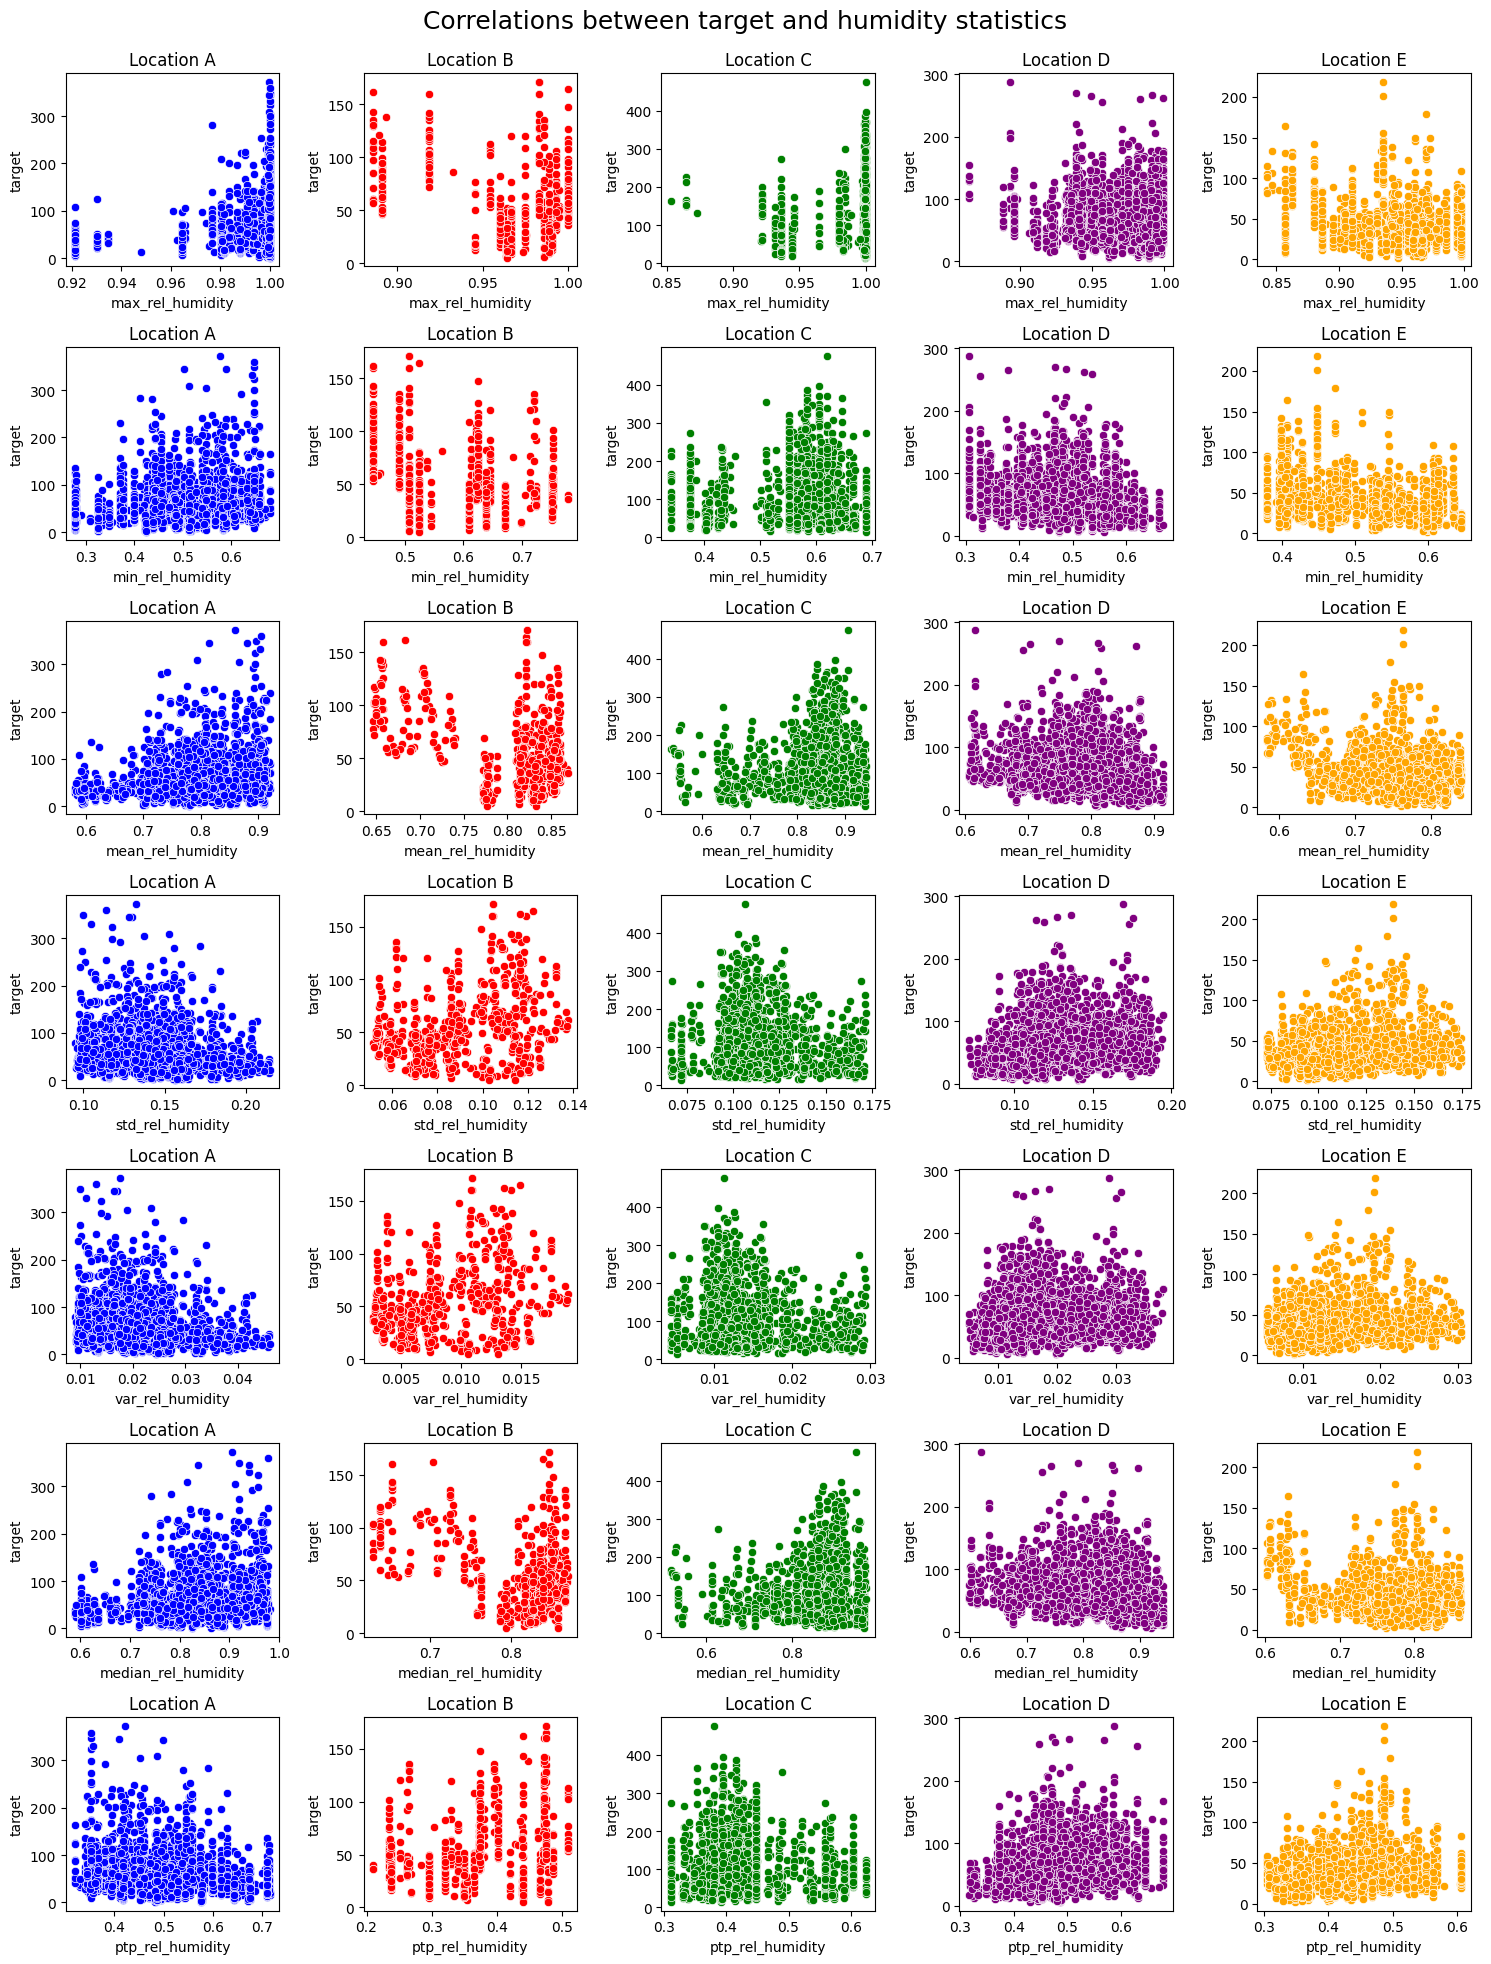

In [27]:
plot_scatter(df_filtered, df_filtered.columns[22:29].tolist(), 'Correlations between target and humidity statistics')

In [28]:
df_filtered.columns[29:36]

Index(['max_wind_dir', 'min_wind_dir', 'mean_wind_dir', 'std_wind_dir',
       'var_wind_dir', 'median_wind_dir', 'ptp_wind_dir'],
      dtype='object')

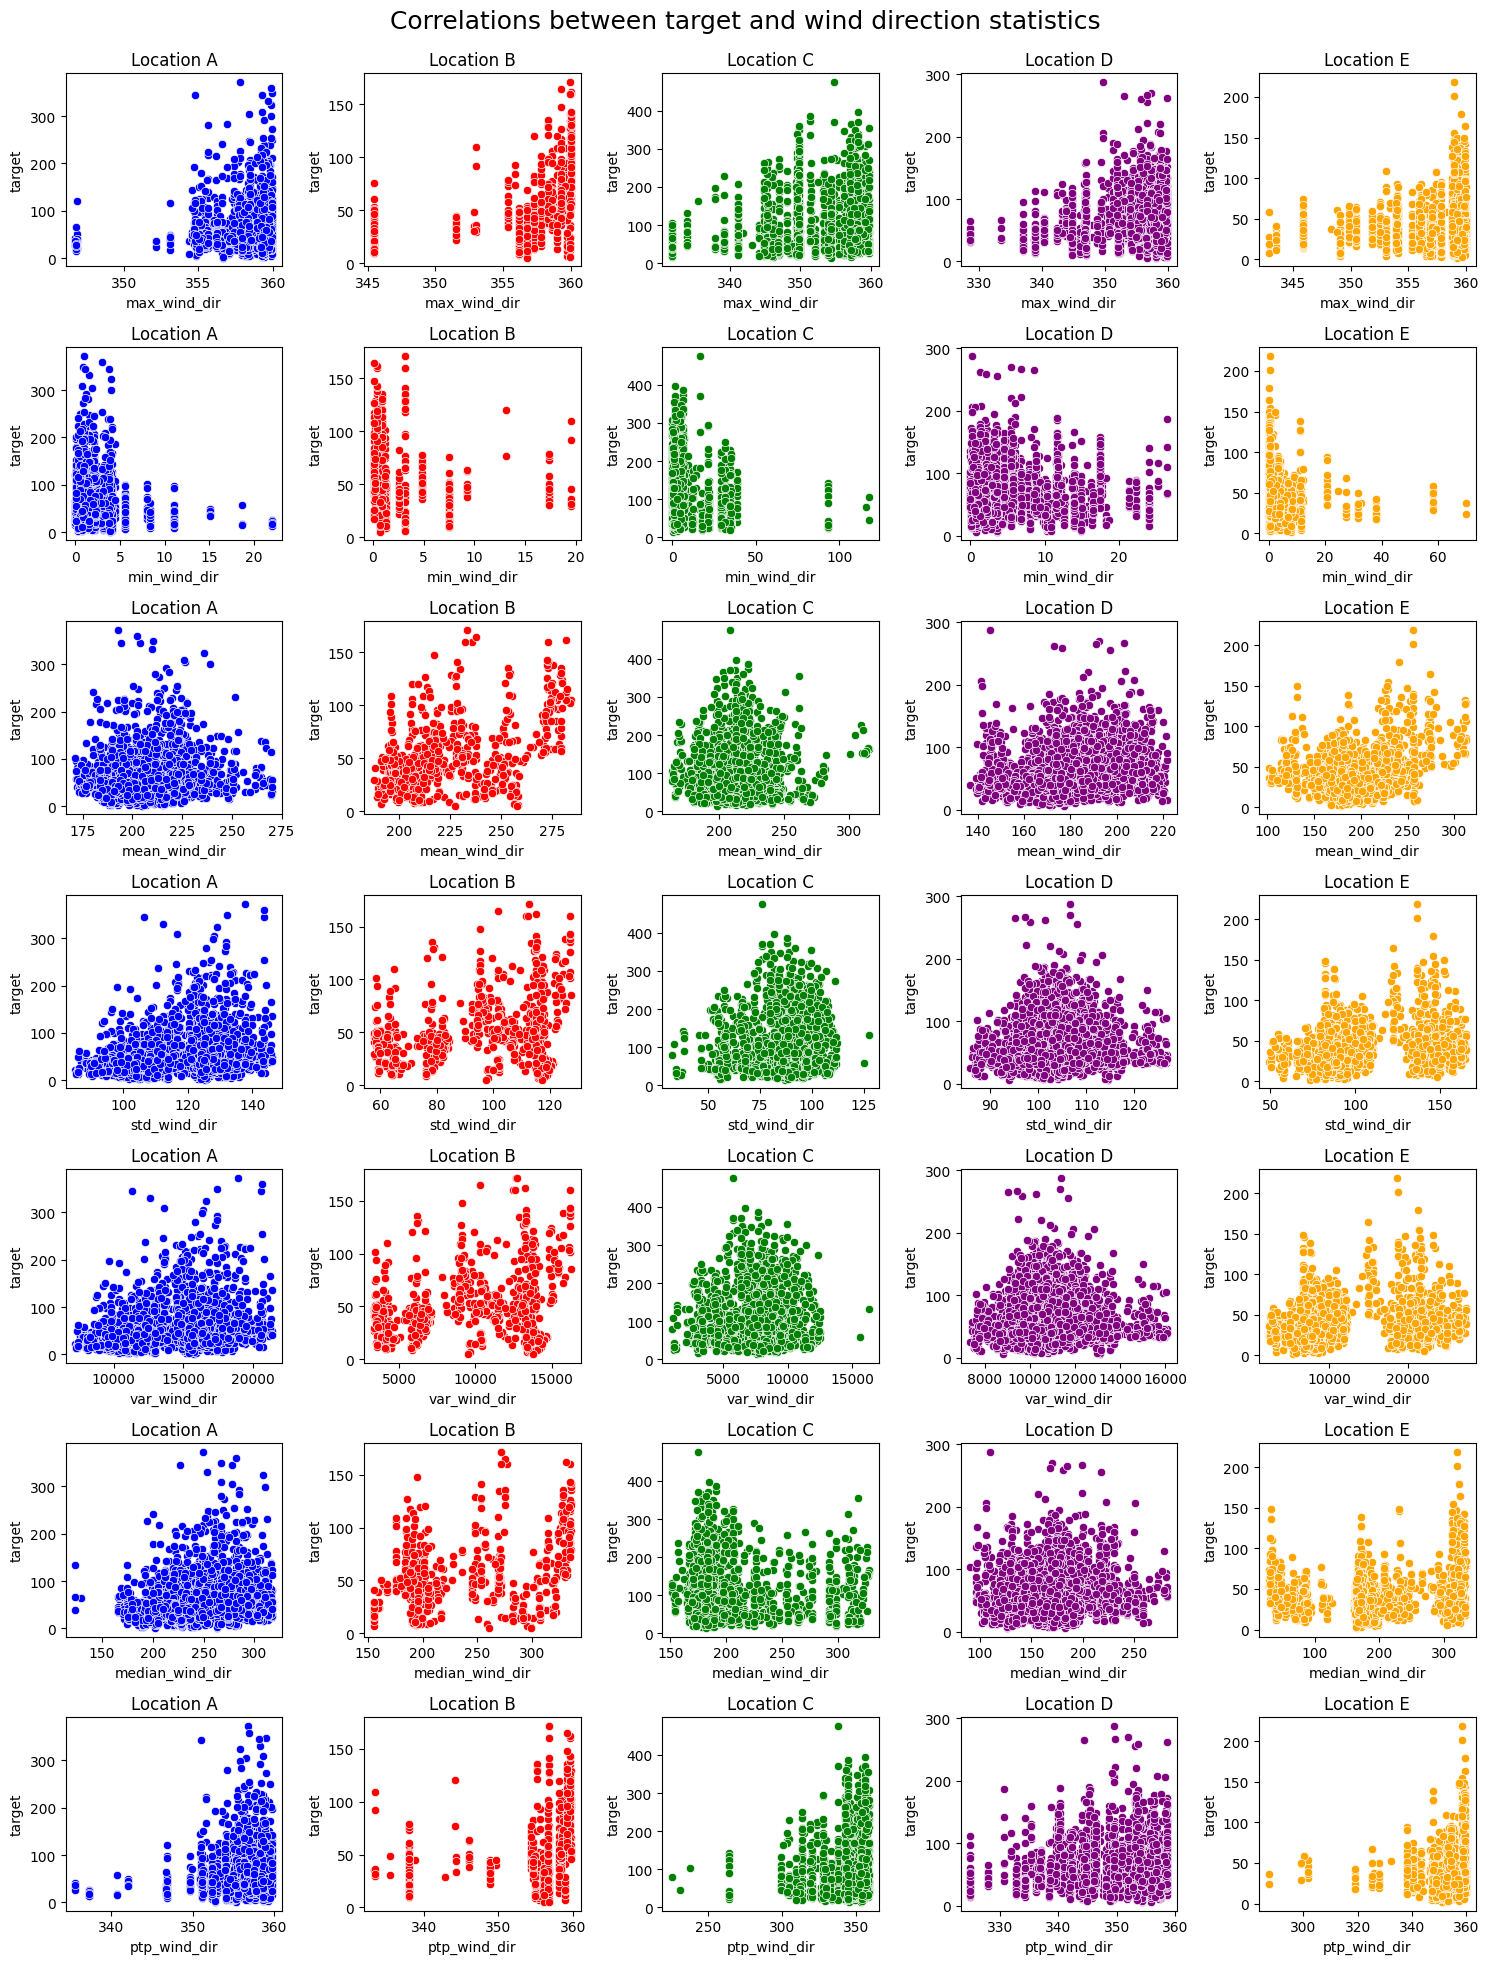

In [29]:
plot_scatter(df_filtered, df_filtered.columns[29:36].tolist(), 'Correlations between target and wind direction statistics')

In [30]:
df_filtered.columns[36:43]

Index(['max_wind_spd', 'min_wind_spd', 'mean_wind_spd', 'std_wind_spd',
       'var_wind_spd', 'median_wind_spd', 'ptp_wind_spd'],
      dtype='object')

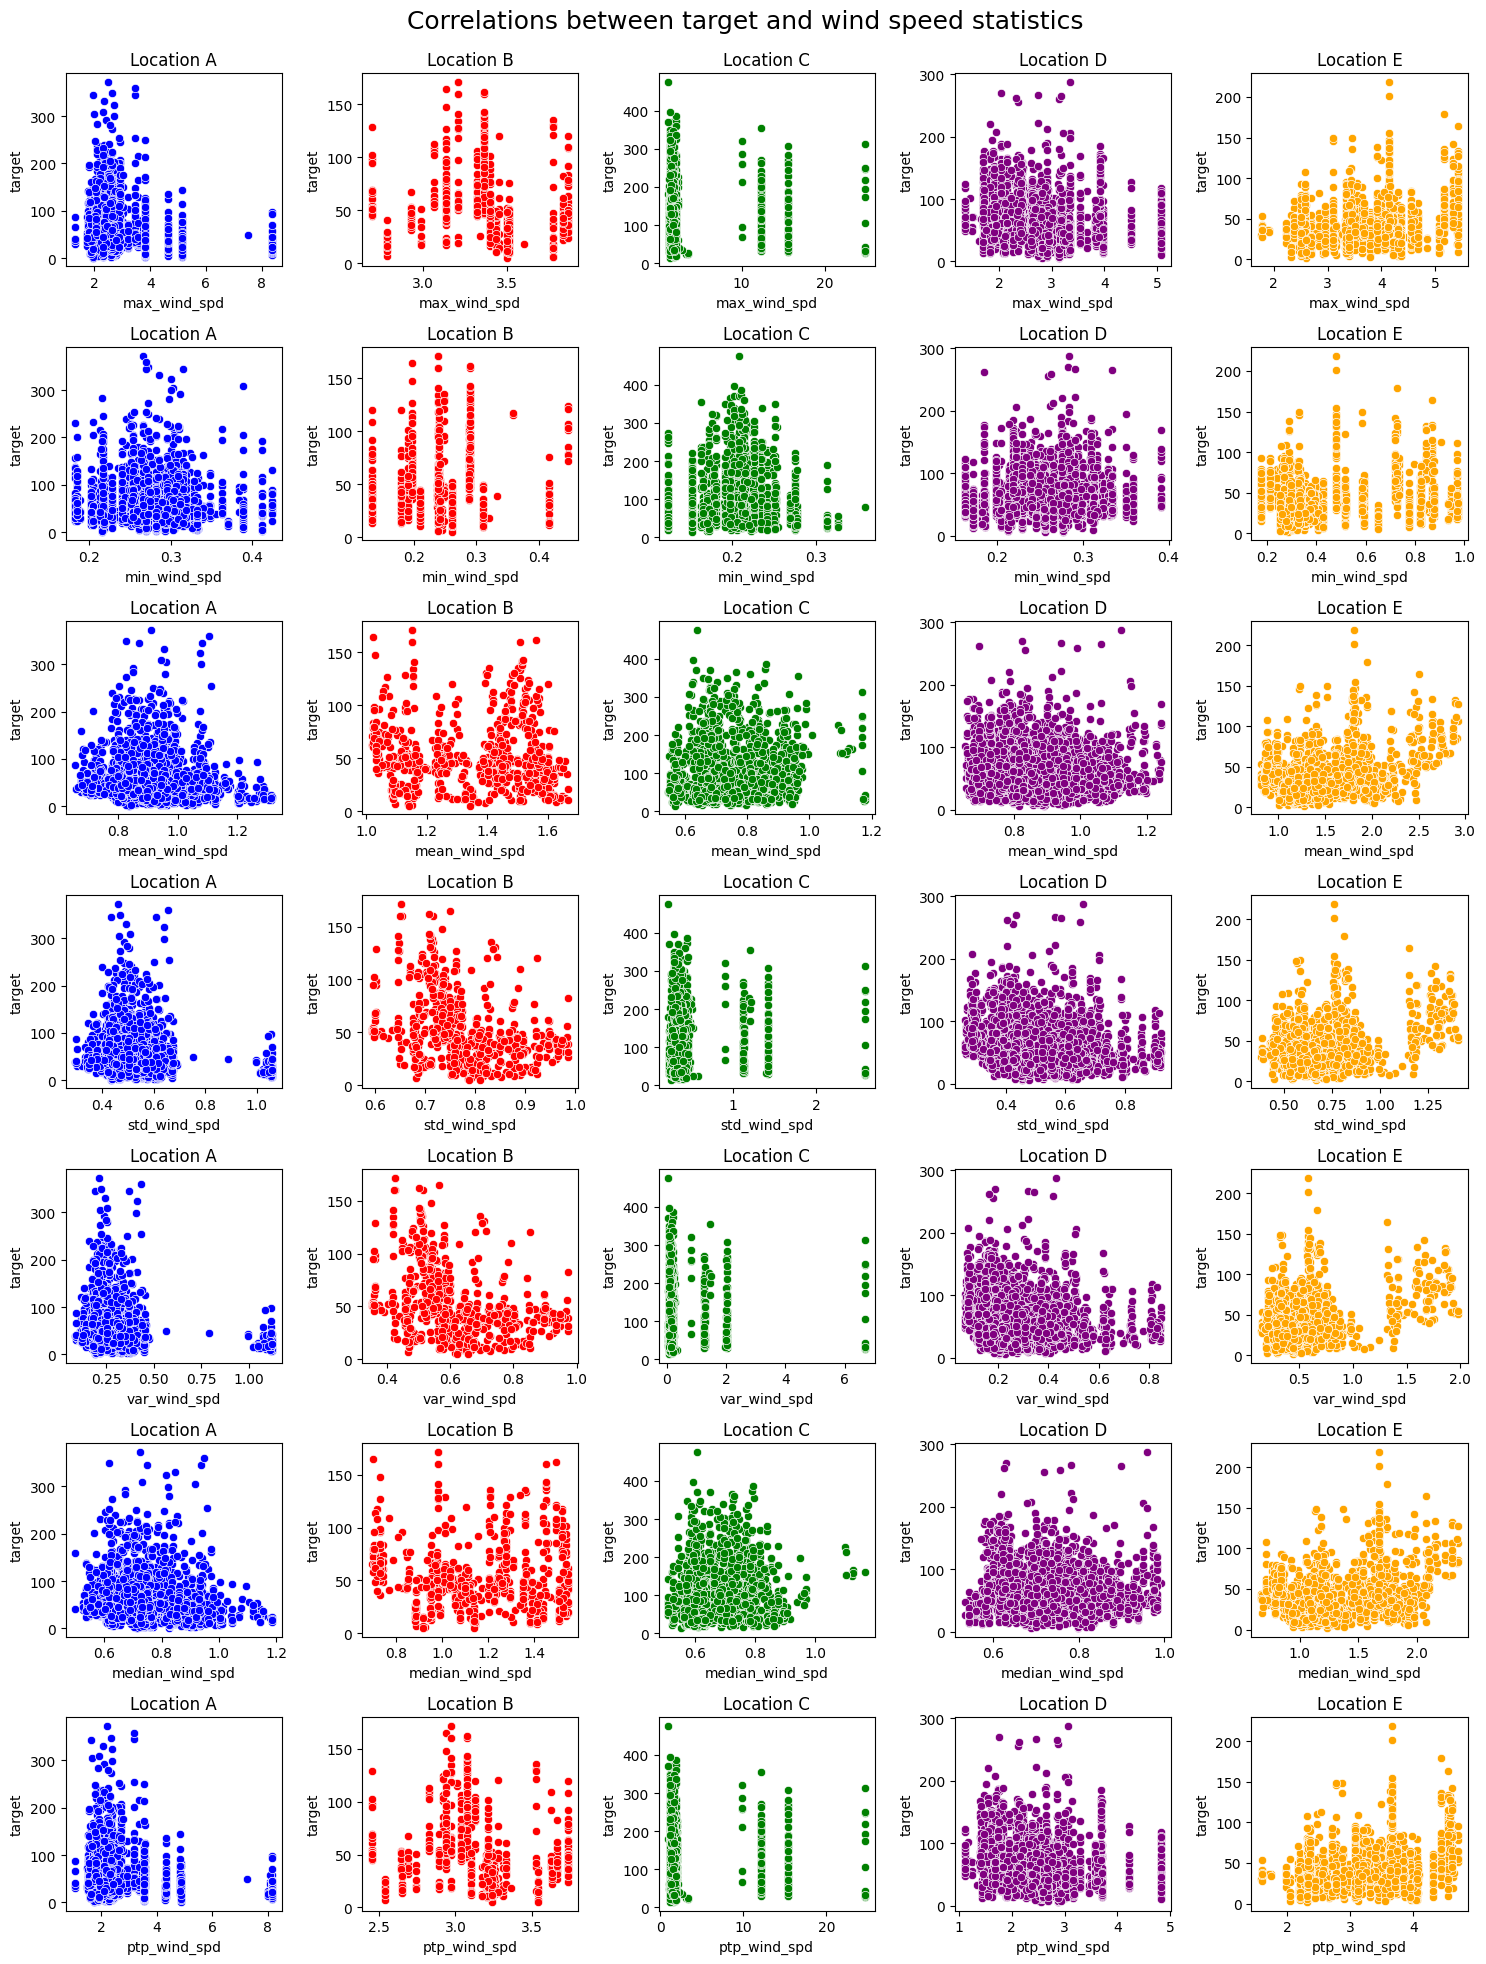

In [31]:
plot_scatter(df_filtered, df_filtered.columns[36:43].tolist(), 'Correlations between target and wind speed statistics')

In [32]:
df_filtered.columns[43:50]

Index(['max_atmos_press', 'min_atmos_press', 'mean_atmos_press',
       'std_atmos_press', 'var_atmos_press', 'median_atmos_press',
       'ptp_atmos_press'],
      dtype='object')

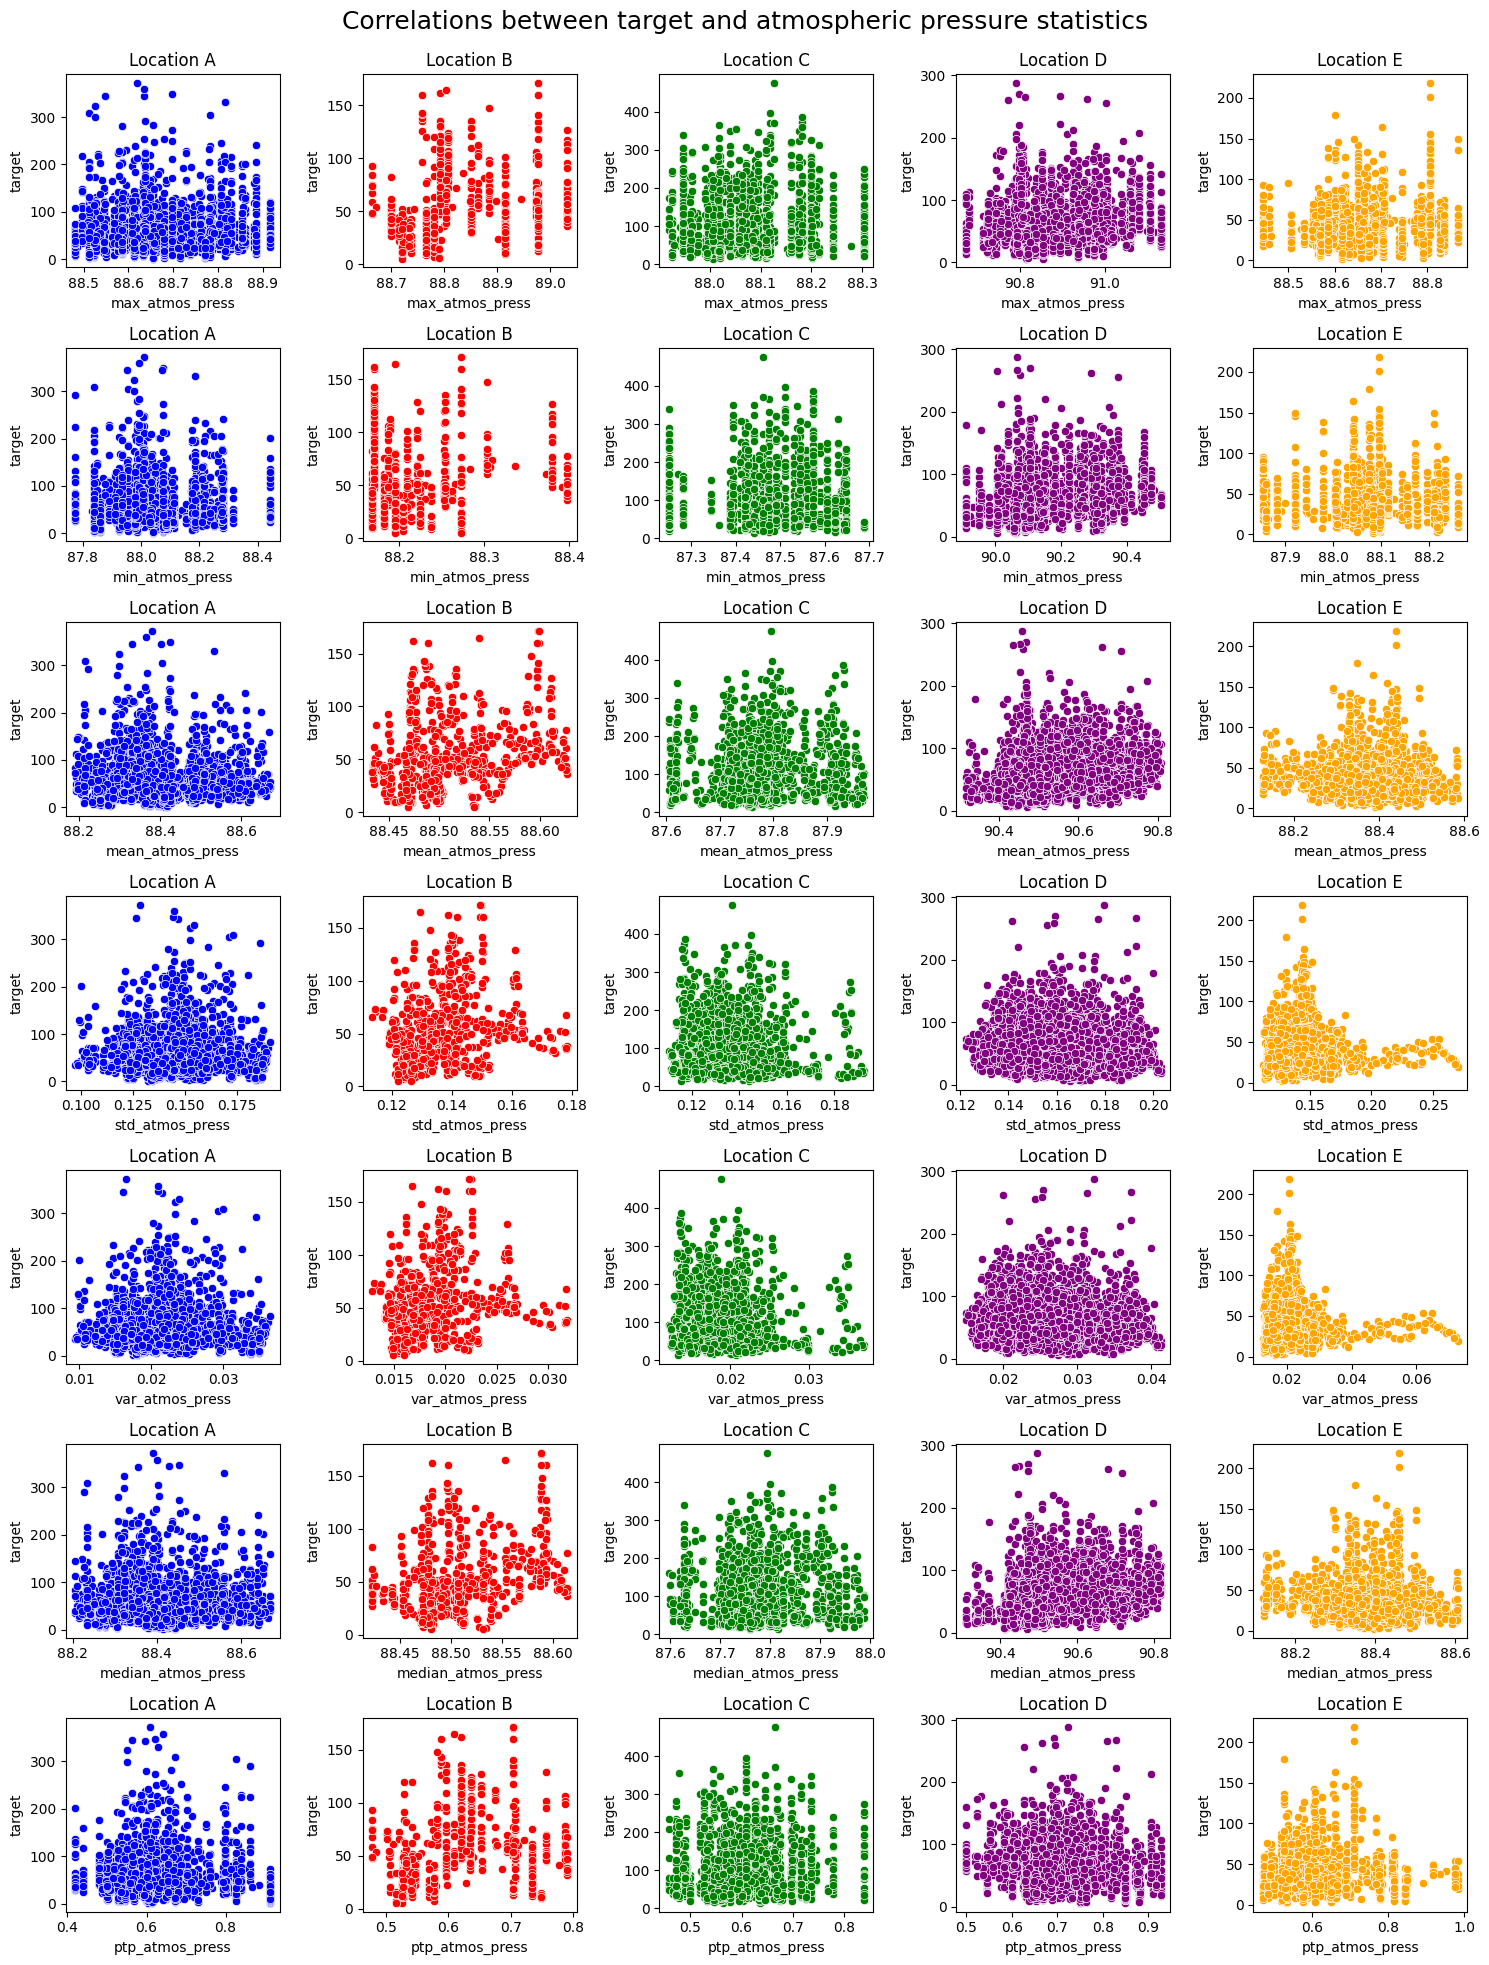

In [33]:
plot_scatter(df_filtered, df_filtered.columns[43:50].tolist(), 'Correlations between target and atmospheric pressure statistics')

#### log-transform target variable since it is strongly skewed

In [34]:
df_filtered['log_target'] = np.log10(df_filtered.target)

/var/folders/dn/n_6mm8pj72738s4ygylk0sgm0000gn/T/ipykernel_2789/216964214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_target'] = np.log10(df_filtered.target)


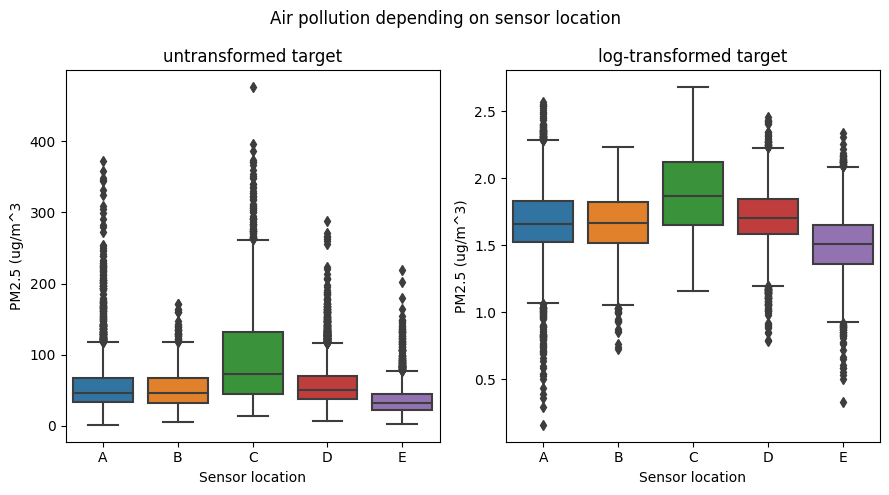

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Air pollution depending on sensor location')

plot1 = sns.boxplot(data=df_filtered, x='location', y='target', ax=ax1, order=['A', 'B', 'C', 'D', 'E'])
ax1.set_title('untransformed target')
ax1.set_ylabel('PM2.5 (ug/m^3')
ax1.set_xlabel('Sensor location')

plot2 = sns.boxplot(data=df_filtered, x='location', y='log_target', ax=ax2, order=['A', 'B', 'C', 'D', 'E'])
ax2.set_title('log-transformed target')
ax2.set_ylabel('PM2.5 (ug/m^3)')
ax2.set_xlabel('Sensor location')

plt.tight_layout();

### Calculate improved Ridge regression model with a set of different summary features

In [36]:
# import libraries and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [37]:
# get target and features
X = df_filtered[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press',
                'std_temp', 'std_precip', 'std_rel_humidity', 'std_wind_dir', 'std_wind_spd', 'std_atmos_press']]
y = df_filtered['target']

print(X.shape)
print(y.shape)

(13522, 13)
(13522,)


In [38]:
#dummy-encode the location feature
location = pd.get_dummies(X['location'], prefix='location',drop_first=True)
location.head()

location_B  location_C  location_D  location_E
ID                                                            
ID_train_1               0           0           1           0
ID_train_10000           0           0           0           1
ID_train_10001           0           1           0           0
ID_train_10002           0           0           0           0
ID_train_10005           0           0           1           0

In [39]:
# concatenate dummy-encoded locations feature to original dataframe
X = pd.concat([X, location],axis = 1)
X.head()

location  mean_temp  mean_precip  mean_rel_humidity  \
ID                                                                   
ID_train_1            D  24.679063     0.007025           0.758058   
ID_train_10000        E  22.581950     0.572736           0.795031   
ID_train_10001        C  23.638430     0.057628           0.725441   
ID_train_10002        A  22.624518     0.634215           0.807800   
ID_train_10005        D  23.189507     0.094843           0.789361   

                mean_wind_dir  mean_wind_spd  mean_atmos_press  std_temp  \
ID                                                                         
ID_train_1         177.109855       0.899208         90.429924  4.266955   
ID_train_10000     168.296246       1.133221         88.437645  2.822580   
ID_train_10001     208.343221       0.957961         87.717645  2.785974   
ID_train_10002     225.092811       0.908583         88.212652  3.535216   
ID_train_10005     157.660400       1.101989         90.624814  4.432786   

                std_precip  std_rel_humidity  std_wind_dir  std_wind_spd  \
ID                                                                         
ID_train_1        0.051706          0.160952     96.802929      0.539199   
ID_train_10000    2.658583          0.102455     82.076698      0.531331   
ID_train_10001    0.279656          0.141222     76.406833      0.445947   
ID_train_10002    4.116347          0.149352    114.350568      0.475694   
ID_train_10005    0.936545          0.168079    116.494268      0.730600   

                std_atmos_press  location_B  location_C  location_D  \
ID                                                                    
ID_train_1             0.156000           0           0           1   
ID_train_10000         0.147604           0           0           0   
ID_train_10001         0.121492           0           1           0   
ID_train_10002         0.169373           0           0           0   
ID_train_10005         0.179998           0           0           1   

                location_E  
ID                          
ID_train_1               0  
ID_train_10000           1  
ID_train_10001           0  
ID_train_10002           0  
ID_train_10005           0

In [40]:
# perform train test split, stratified by location in order to ensure that locations are balanced between training and test set
rseed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['location'], random_state=rseed)

print(X_train.shape)
print(X_test.shape)

(9465, 17)
(4057, 17)


In [41]:
X_train.columns

Index(['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity',
       'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press', 'std_temp',
       'std_precip', 'std_rel_humidity', 'std_wind_dir', 'std_wind_spd',
       'std_atmos_press', 'location_B', 'location_C', 'location_D',
       'location_E'],
      dtype='object')

In [42]:
# scale features using z-transformation
scaler = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled = scaler.fit_transform(X_train[['mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_spd', 'mean_atmos_press',
                'std_temp', 'std_precip', 'std_rel_humidity', 'std_wind_dir', 'std_wind_spd', 'std_atmos_press']])
# aply transform to test data
X_test_scaled = scaler.transform(X_test[['mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_spd', 'mean_atmos_press',
                'std_temp', 'std_precip', 'std_rel_humidity', 'std_wind_dir', 'std_wind_spd', 'std_atmos_press']])

In [43]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(9465, 11)
(4057, 11)


In [44]:
# combine scaled metric features and dummy-encoded location features
X_train_preprocessed = np.concatenate([X_train_scaled, X_train[['location_B', 'location_C', 'location_D', 'location_E']]], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test[['location_B', 'location_C', 'location_D', 'location_E']]], axis=1)

print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)

(9465, 15)
(4057, 15)


#### First calculate linear regression model

In [45]:
# train the model
linreg = LinearRegression()

linreg.fit(X_train_preprocessed, y_train)

LinearRegression()

In [46]:
# get beta coefficients
linreg.coef_

array([ -4.33992725,  -7.2442333 ,  -6.25487959,  -5.0952021 ,
        13.24013926,   8.0280068 ,   6.41160078,  -7.31076863,
         5.43165224,   1.18320477,   1.58047372,   8.44802901,
        61.43130286, -28.79533572, -10.99911892])

In [47]:
# predict new cases
y_pred = linreg.predict(X_test_preprocessed)

# evaluate model accurray

rmse_linreg = mean_squared_error(y_test, y_pred, squared=False)
r2_linreg = r2_score(y_test, y_pred)

print(f'RMSE on testset: {round(rmse_linreg,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg,2)}')

RMSE on testset: 38.92
Coefficient of determination on testset: 0.18


### Residual plot

In [48]:
# calculate residuals
residual = y_test - y_pred

# compute mean of residuals
np.mean(residual)

0.23611220948945488

Thus, on average, our baseline model rather seems to underestimate the air pollution, as indicated by an average residual error > 0.

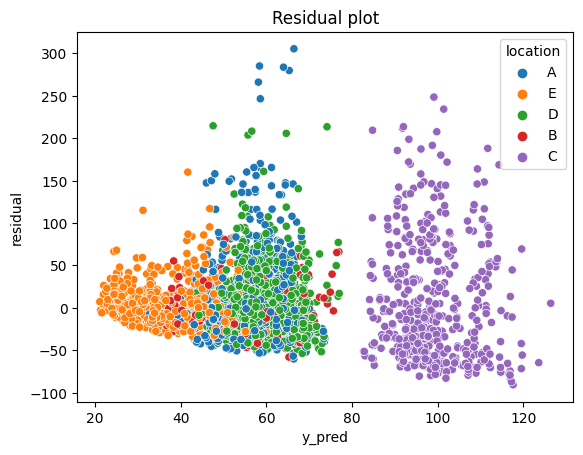

In [49]:
sns.scatterplot(x=y_pred, y=residual, hue=X_test['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot');

#### Calculate Ridge regression model

##### Find best hyperparameters using GridSearch

In [50]:
ridge = Ridge()
ridge.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

In [51]:
# define parameter grid
param_grid = {'alpha': [0.1, 1, 10],
                'solver': ['sparse_cg', 'lsqr', 'saga']}

# instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(Ridge(random_state=42), param_grid, scoring='neg_root_mean_squared_error',
                  cv=5, verbose=5, n_jobs=-1)

gs.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....alpha=0.1, solver=sparse_cg;, score=-40.338 total time=   0.0s
[CV 4/5] END ..........alpha=0.1, solver=lsqr;, score=-36.722 total time=   0.0s
[CV 5/5] END ..........alpha=0.1, solver=lsqr;, score=-37.840 total time=   0.0s
[CV 3/5] END .....alpha=0.1, solver=sparse_cg;, score=-38.887 total time=   0.0s
[CV 1/5] END ..........alpha=0.1, solver=saga;, score=-40.338 total time=   0.1s
[CV 2/5] END .....alpha=0.1, solver=sparse_cg;, score=-38.716 total time=   0.0s
[CV 2/5] END ..........alpha=0.1, solver=saga;, score=-38.715 total time=   0.1s
[CV 4/5] END .....alpha=0.1, solver=sparse_cg;, score=-36.734 total time=   0.0s
[CV 1/5] END ..........alpha=0.1, solver=lsqr;, score=-40.356 total time=   0.0s
[CV 2/5] END ..........alpha=0.1, solver=lsqr;, score=-38.726 total time=   0.0s
[CV 3/5] END ..........alpha=0.1, solver=lsqr;, score=-38.968 total time=   0.0s
[CV 5/5] END .....alpha=0.1, solver=sparse_cg;, s

GridSearchCV(cv=5, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10],
                         'solver': ['sparse_cg', 'lsqr', 'saga']},
             scoring='neg_root_mean_squared_error', verbose=5)

In [52]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: -38.507
Best parameters: {'alpha': 1, 'solver': 'sparse_cg'}


#### Retrain best model on whole training set

In [53]:
# save best model
ridge_best = gs.best_estimator_
ridge_best

Ridge(alpha=1, random_state=42, solver='sparse_cg')

In [54]:
ridge_best.fit(X_train_preprocessed, y_train)

Ridge(alpha=1, random_state=42, solver='sparse_cg')

In [55]:
y_pred_ridge = ridge_best.predict(X_test_preprocessed)

In [56]:
# evaluate model accurray
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'RMSE on testset: {round(rmse_ridge,2)}')
print(f'Coefficient of determination on testset: {round(r2_ridge,2)}')

RMSE on testset: 38.92
Coefficient of determination on testset: 0.18


In [57]:
# calculate residuals
residual_ridge = y_test - y_pred_ridge

# compute mean of residuals
np.mean(residual_ridge)

0.23396570591952445

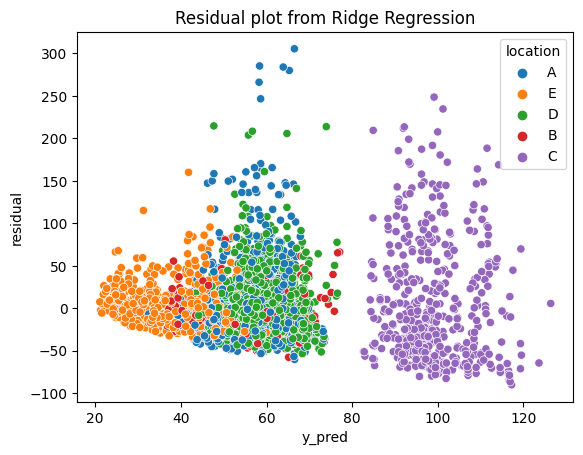

In [58]:
sns.scatterplot(x=y_pred_ridge, y=residual_ridge, hue=X_test['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot from Ridge Regression');

### Calculate Decision Tree Regressor

In [60]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
dec_tree = DecisionTreeRegressor()  
  
# get hyperparameters
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [65]:
tree_params = {'max_depth': [10, 20, 30, 40, 50],
                'min_samples_leaf': [5, 10, 15, 20],
                'max_leaf_nodes': [100, 200, 500, 1000]}

grid_tree = GridSearchCV(DecisionTreeRegressor(), tree_params, scoring='neg_root_mean_squared_error',
                  cv=5, verbose=5, n_jobs=-1)

grid_tree.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-38.023 total time=   0.1s
[CV 4/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-34.607 total time=   0.1s
[CV 5/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-36.824 total time=   0.1s
[CV 1/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=10;, score=-37.484 total time=   0.1s
[CV 3/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-37.564 total time=   0.1s
[CV 2/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-36.766 total time=   0.1s
[CV 2/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=10;, score=-37.342 total time=   0.1s
[CV 3/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=10;, score=-37.399 total time=   0.1s
[CV 2/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=15;, score=-35.807 total time=   0.0s
[CV 4/5] END max_depth=10

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'max_leaf_nodes': [100, 200, 500, 1000],
                         'min_samples_leaf': [5, 10, 15, 20]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [66]:
# Best score
print('Best score:', round(grid_tree.best_score_, 3))

# Best parameters
print('Best parameters:', grid_tree.best_params_)

Best score: -34.824
Best parameters: {'max_depth': 20, 'max_leaf_nodes': 1000, 'min_samples_leaf': 10}


#### retrain on whole training set

In [69]:
# save best model
dectree_best = grid_tree.best_estimator_
dectree_best

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=1000, min_samples_leaf=10)

In [70]:
dectree_best.fit(X_train_preprocessed, y_train)

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=1000, min_samples_leaf=10)

In [71]:
y_pred_dectree = dectree_best.predict(X_test_preprocessed)

In [72]:
# evaluate model accurray
rmse_dectree = mean_squared_error(y_test, y_pred_dectree, squared=False)
r2_dectree = r2_score(y_test, y_pred_dectree)

print(f'RMSE on testset: {round(rmse_dectree,2)}')
print(f'Coefficient of determination on testset: {round(r2_dectree,2)}')

RMSE on testset: 34.89
Coefficient of determination on testset: 0.34


In [73]:
# calculate residuals
residual_dectree = y_test - y_pred_dectree

# compute mean of residuals
np.mean(residual_dectree)

-0.05675106085447874

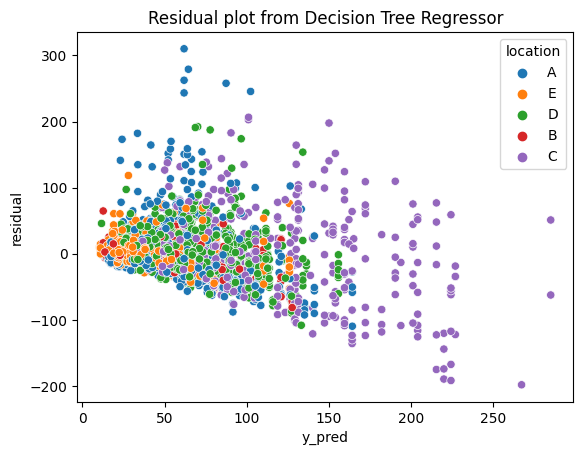

In [74]:
sns.scatterplot(x=y_pred_dectree, y=residual_dectree, hue=X_test['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot from Decision Tree Regressor');

### Calculate Random Forest Regressor

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
# create a rf object 
rf = RandomForestRegressor()
  
# get hyperparameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [77]:
rf_params = {'max_depth': [10, 20, 30, 40, 50],
                'min_samples_leaf': [5, 10, 15, 20],
                'max_leaf_nodes': [100, 200, 500, 1000]}

grid_rf = GridSearchCV(RandomForestRegressor(), tree_params, scoring='neg_root_mean_squared_error',
                  cv=5, verbose=5, n_jobs=-1)

grid_rf.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=10;, score=-34.947 total time=   3.4s
[CV 2/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-33.339 total time=   3.6s
[CV 2/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=10;, score=-33.719 total time=   3.5s
[CV 3/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-33.409 total time=   3.8s
[CV 1/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-34.648 total time=   3.8s
[CV 5/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-32.419 total time=   3.9s
[CV 3/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=10;, score=-34.308 total time=   3.8s
[CV 4/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=5;, score=-31.708 total time=   4.0s
[CV 4/5] END max_depth=10, max_leaf_nodes=100, min_samples_leaf=10;, score=-31.968 total time=   3.7s
[CV 5/5] END max_depth=10

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'max_leaf_nodes': [100, 200, 500, 1000],
                         'min_samples_leaf': [5, 10, 15, 20]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [78]:
# Best score
print('Best score:', round(grid_rf.best_score_, 3))

# Best parameters
print('Best parameters:', grid_rf.best_params_)

Best score: -30.511
Best parameters: {'max_depth': 40, 'max_leaf_nodes': 1000, 'min_samples_leaf': 5}


#### retrain on whole training set

In [79]:
# save best model
rf_best = grid_rf.best_estimator_
rf_best

RandomForestRegressor(max_depth=40, max_leaf_nodes=1000, min_samples_leaf=5)

In [80]:
rf_best.fit(X_train_preprocessed, y_train)

RandomForestRegressor(max_depth=40, max_leaf_nodes=1000, min_samples_leaf=5)

In [81]:
y_pred_rf = rf_best.predict(X_test_preprocessed)

In [82]:
# evaluate model accurray
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE on testset: {round(rmse_rf,2)}')
print(f'Coefficient of determination on testset: {round(r2_rf,2)}')

RMSE on testset: 30.28
Coefficient of determination on testset: 0.5


In [83]:
# calculate residuals
residual_rf = y_test - y_pred_rf

# compute mean of residuals
np.mean(residual_rf)

-0.3587767672740266

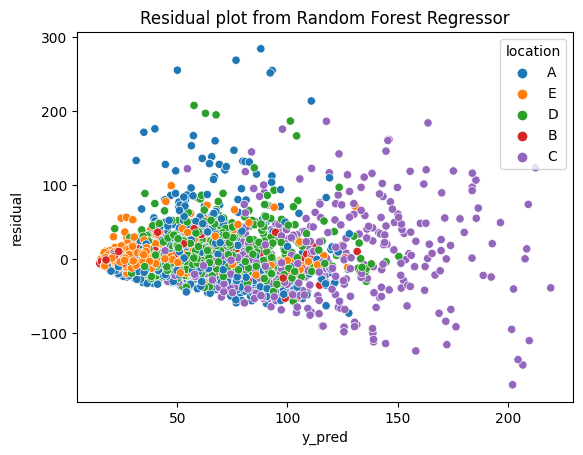

In [84]:
sns.scatterplot(x=y_pred_rf, y=residual_rf, hue=X_test['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot from Random Forest Regressor');